# CRISP-DM Project: Deep Analysis for Seattle AirBNB Data

## 1. Business Understanding.

### The following questions will be addressed in the article:

- When is the most popular season(highest price for the lodging)in Seattle?
- Which neighborhood is the most expensive in Seattle?
- Price Prediction for Airbnb in Seattle.
- What are the top factors that affects the price of Airbnb?

## 2. Data Understanding:

### Data Preprocessing:

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import GridSearchCV


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [3]:
calendar = pd.read_csv('./calendar.csv')
listings = pd.read_csv('./listings.csv')
reviews = pd.read_csv('./reviews.csv')

In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [8]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [9]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

In [10]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [11]:
month_average = calendar.groupby(calendar['date'].dt.strftime('%B'))['price'].mean().sort_values(ascending=True)

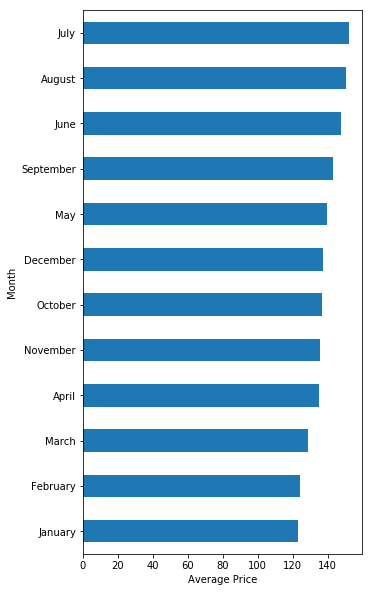

In [12]:
month_average.plot.barh(figsize=(5,10))
plt.xlabel('Average Price')
plt.ylabel('Month')

plt.show()

### Discussion: 

we can tell that June, July, August, September have the highest average price for Airbnb. Since the weather during these months in Seattle is always good, it makes sense that prices in these months are higher compared to others.

In [13]:
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

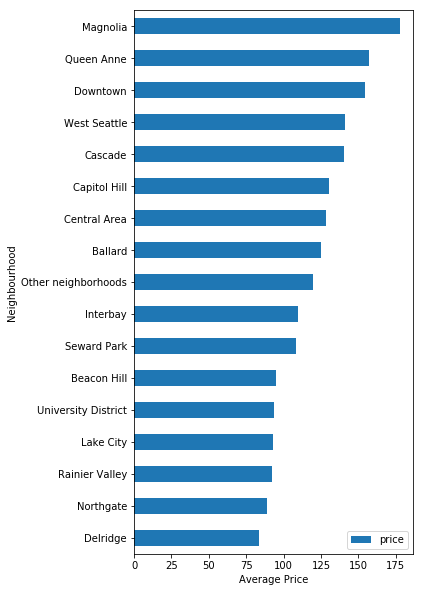

In [14]:
most_expensive_neighborhood = listings.groupby(['neighbourhood_group_cleansed'])[['price']].mean().sort_values(by='price')
most_expensive_neighborhood.plot.barh(figsize=(5,10))
plt.xlabel('Average Price')
plt.ylabel('Neighbourhood')

plt.show()

### Discussion:
    
Based on the plot, the top 5 expensive neighborhoods are Magnolia, Queen Anne, Downtown, West Seattle, Cascade.

## 3.Prepare Data

In [15]:
missing_data = pd.Series(listings.isnull().sum() / len(listings))

In [16]:
missing_data_columns = missing_data[missing_data > 0.4].index.tolist()

In [17]:
print(missing_data_columns)

['notes', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'license']


In [18]:
listings.drop(missing_data_columns, axis = 1, inplace = True)

### Discussion:
    
The following categorical columns will be dropped for further analysis.

In [19]:
listings.drop(['id','listing_url','scrape_id','last_scraped','name', 'summary',
               'space','description','experiences_offered','neighborhood_overview','transit',
               'thumbnail_url','medium_url','picture_url','xl_picture_url','host_id',
               'host_url','host_name','host_since','host_location','host_about','host_thumbnail_url',
                'host_picture_url','host_neighbourhood','host_verifications', 'street','neighbourhood','city',
               'state','zipcode','market','smart_location','country_code', 'country','amenities',
               'calendar_last_scraped','first_review', 'last_review','jurisdiction_names','host_acceptance_rate',
               'calendar_updated','has_availability','requires_license'
                ], axis = 1, inplace = True)

In [20]:
listings['extra_people'] = listings['extra_people'].replace('[\$,]', '', regex=True).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
listings['host_response_rate'] = listings['host_response_rate'].replace( '%','', regex=True ).astype(float)

In [21]:
listings.isnull().values.any()

True

In [22]:
for each in listings.columns:
    listings[each] = listings[each].fillna(listings[each].mode()[0])

In [23]:
# Checking if there is any missing value 

listings.isnull().values.any()

False

In [24]:
# The categorical columns that need to be converted

categorical_column = []

for each in listings.columns:
    if listings[each].dtypes == 'object':
        categorical_column.append(each)
print(categorical_column)

['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']


In [25]:
# Convert the categorical variable into numerical
listings = pd.get_dummies(data=listings, columns=categorical_column)

In [26]:
listings.head()

,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,...,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,is_location_exact_f,is_location_exact_t,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,96.0,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,50.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,4.07,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0
1,98.0,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,150.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,6,1.48,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1
2,67.0,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,975.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,1.15,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0
3,100.0,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,100.0,50.0,1,0.0,1,1125,0,0,0,143,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.00,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0
4,100.0,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,450.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0.89,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0


In [27]:
listings.drop(['host_is_superhost_f','host_has_profile_pic_f','host_identity_verified_f',
              'is_location_exact_f','instant_bookable_f','require_guest_profile_picture_f',
               'require_guest_phone_verification_f'             
              ], axis=1, inplace=True)

In [28]:
listings.head()

,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,...,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,is_location_exact_t,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t
0,96.0,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,50.0,2,5.0,1,365,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,4.07,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
1,98.0,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,150.0,40.0,1,0.0,2,90,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,6,1.48,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1
2,67.0,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,975.0,300.0,10,25.0,4,30,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,1.15,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,100.0,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,100.0,50.0,1,0.0,1,1125,0,0,0,143,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1.00,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,100.0,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,450.0,125.0,6,15.0,1,1125,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0.89,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0

In [29]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 171 entries, host_response_rate to require_guest_phone_verification_t
dtypes: float64(19), int64(10), uint8(142)
memory usage: 1.4 MB


In [30]:
scaler = StandardScaler()
        
listings[listings.columns] = scaler.fit_transform(listings[listings.columns])

In [31]:
listings.head()

,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,...,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,is_location_exact_t,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t
0,0.036982,-0.145176,-0.145176,0.170240,-1.194754,0.329029,-0.438461,-0.348068,-0.645342,-0.476252,-0.203405,0.249756,-0.322324,-0.083987,-0.246795,-0.228908,0.179356,0.379264,0.798601,4.897864,-0.073074,0.463260,0.493761,0.322356,0.302353,-1.143552,0.636022,-0.160602,1.265746,-0.100264,-0.430518,1.715871,-1.175493,-0.505886,0.042858,0.522581,-0.136662,-0.105465,-0.036212,-0.118647,-0.255519,-0.058451,-0.060666,-0.058451,-0.066877,-0.340658,-0.087486,-0.045823,-0.16651,-0.1242,...,-0.051245,-0.066877,-0.253185,-0.178583,-0.417622,-0.154489,-0.327089,-0.145357,-0.401488,-0.053753,-0.133648,-0.127422,-0.146294,-0.512412,3.455774,-0.208457,-0.107976,-0.181683,-0.23697,0.344952,1.111469,-0.098923,-0.045823,-0.058451,-0.074369,-0.058451,-0.022893,-0.156258,-0.022893,-0.912170,-0.102896,-0.076129,-0.036212,-0.178583,-0.028042,-0.016186,0.708913,-0.66062,-0.177801,-0.084393,-0.058451,-0.140588,-0.11164,0.209822,-0.427951,-0.656532,1.432466,-0.768226,-0.302974,-0.330025
1,0.216167,-0.040344,-0.040344,0.236078,-1.025923,0.329029,-0.438461,-0.348068,-0.645342,0.244063,-0.441262,-0.513098,-0.606680,-0.022651,-0.410158,-0.311063,-1.020585,-1.235563,0.364696,0.550724,0.084196,0.463260,0.493761,0.322356,0.302353,0.548072,0.636022,0.518255,-0.246193,-0.100264,-0.430518,-0.582794,0.850707,1.976728,0.042858,0.522581,-0.136662,-0.105465,-0.036212,

## 4.Model Data

In [32]:
# Split the data into features and target label
target = listings['price']
features = listings.drop('price', axis = 1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 60)

In [34]:
parameters = {
              'n_estimators': [100,150,200], 
              'learning_rate': [0.1,0.2,0.5],
              'min_samples_split': [5,10,20]
              }

clf = GradientBoostingRegressor(random_state = 60)
cv = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
cv.fit(X_train, y_train)
best_clf = cv.best_estimator_    

## 5.Results

In [35]:
key = []
value = []
feature_importances = cv.best_estimator_.feature_importances_
features = sorted(zip(feature_importances, features.columns), reverse=True)

for each in features:
    key.append(each[1]) 
    value.append(each[0])

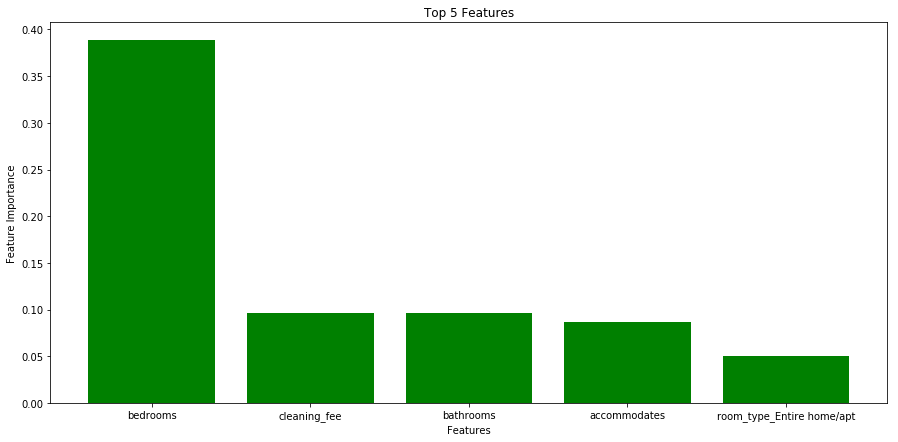

In [42]:
plt.figure(figsize=(15,7))
plt.bar(key[:5], height=value[:5],color='green')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 5 Features')
plt.show()